# 1) Download the Price Data via an API

In [2]:
# A tutorial for this file is available at www.relataly.com

# Remote data access for pandas
import matplotlib.pyplot as plt 
import matplotlib.colors as col 
import pandas as pd 
import matplotlib.cm as cm 
import numpy as np 
from math import log, exp 
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from Historic_Crypto import HistoricalData

# the price frequency in seconds: 21600 = 6 hour price data, 86400 = daily price data
frequency = 21600

# The beginning of the period for which prices will be retrieved
from_date = '2017-01-01-00-00'
# The currency price pairs for which the data will be retrieved
coinlist = ['BTC-USD']


# Query the data
for i in range(len(coinlist)):
    coinname = coinlist[i]
    pricedata = HistoricalData(coinname, frequency, from_date).retrieve_data()
    pricedf = pricedata[['close', 'low', 'high']]
    if i == 0:
        df = pd.DataFrame(pricedf.copy())
    else:
        df = pd.merge(left=df, right=pricedf, how='left', left_index=True, right_index=True)   
    df.rename(columns={"close": "close-" + coinname}, inplace=True)
    df.rename(columns={"low": "low-" + coinname}, inplace=True)
    df.rename(columns={"high": "high-" + coinname}, inplace=True)
df.head()

Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction.
Provisional Start: 2017-01-01T00:00:00
Provisional End: 2017-03-17T00:00:00
Data for chunk 1 of 27 extracted
Provisional Start: 2017-03-17T00:00:00
Provisional End: 2017-05-31T00:00:00
Data for chunk 2 of 27 extracted
Provisional Start: 2017-05-31T00:00:00
Provisional End: 2017-08-14T00:00:00
Data for chunk 3 of 27 extracted
Provisional Start: 2017-08-14T00:00:00
Provisional End: 2017-10-28T00:00:00
Data for chunk 4 of 27 extracted
Provisional Start: 2017-10-28T00:00:00
Provisional End: 2018-01-11T00:00:00
Data for chunk 5 of 27 extracted
Provisional Start: 2018-01-11T00:00:00
Provisional End: 2018-03-27T00:00:00
Data for chunk 6 of 27 extracted
Provisional Start: 2018-03-27T00:00:00
Provisional End: 2018-06-10T00:00:00
Data for chunk 7 of 27 ext

,close-BTC-USD,low-BTC-USD,high-BTC-USD
time,,,
2017-01-01 06:00:00,975.00,964.54,975.00
2017-01-01 12:00:00,994.42,974.01,994.97
2017-01-01 18:00:00,992.95,986.86,1000.00
2017-01-02 00:00:00,1003.64,990.52,1012.00
2017-01-02 06:00:00,1024.84,1002.92,1024.95


# 2) Calculate Logarithmic Regression and Risk Level

In [ ]:
halving_dates = ['2009-03-01', '2012-11-28', '2016-07-09', '2020-05-11', '2024-06-01', '2028-06-01', '2032-06-01']
# Calculate Days to Next Halving Date For Each Date
def get_days_to_halving(df):
    s = pd.to_datetime(df.index[1])
    day_diff_list = []
    for i in range(0, len(df)):
        for s in halving_dates:
            day_diff = datetime.strptime(s, '%Y-%m-%d').date() - df.index[i].date()
            if(day_diff.days >= 0):
                day_diff_list.append(day_diff.days)
                break
    return day_diff_list


# function that converts a given set of indicator values to colors
def get_colors(ind, colormap):
    norm = col.Normalize(vmin=ind.min(), vmax=ind.max())
    colorlist = [list(colormap(norm(i))) for i in ind]
    return colorlist



def func(x, a, b, c):
    return a*np.log10(x + c) + b

x = [x for x in range(len(df))]
y = np.log(np.array(df['Close']))
popt, pcov = curve_fit(func, x, y)
df['log_reg'] =  func(np.array([x for x in range(len(df))]), *popt)

In [ ]:
# --> risk_level
df['risk_level'] = np.log(df['Close'] / df['log_reg'])
y = df['risk_level']

# Convert to Colormap     
cmap = plt.get_cmap('plasma')
df['risk_level_colors'] = get_colors(y, cmap)

C:\Users\Flo\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Flo\anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


# 3) Print Logarithmic Chart color Coded by Days to Next Halving

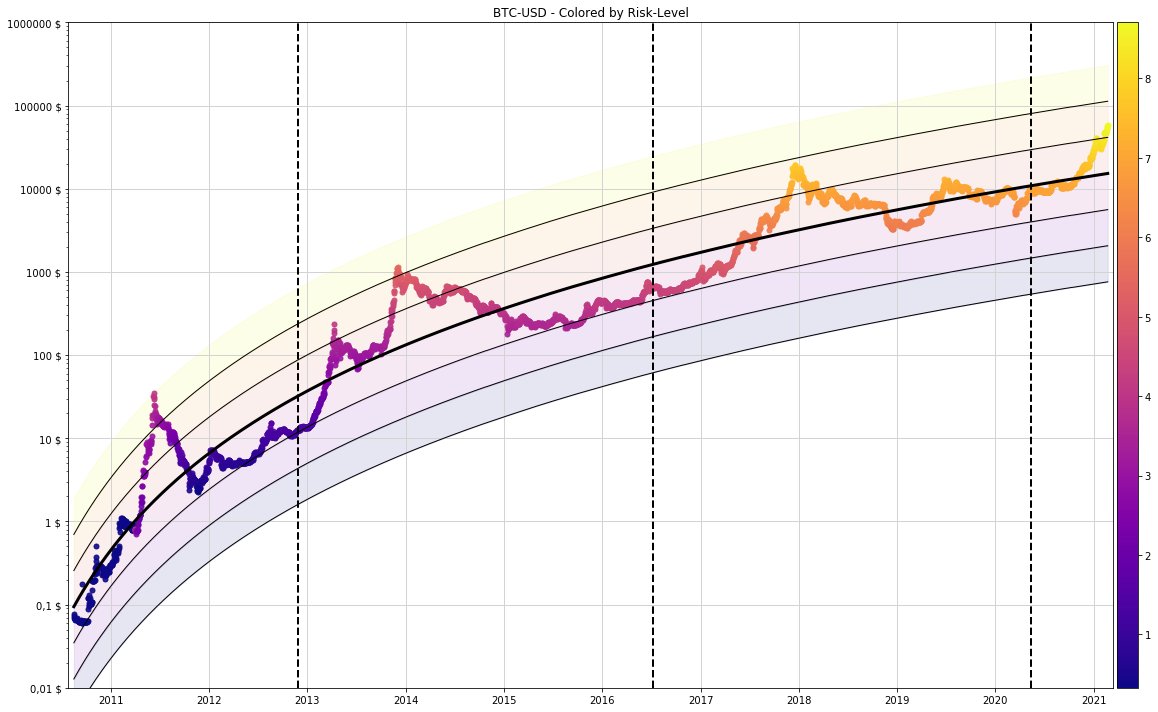

In [ ]:
def defineBar(s, ax, cmap):
    vmin= s.min()
    vmax = s.max()
    m = cm.ScalarMappable(cmap=cmap, norm=col.Normalize(vmin=vmin,vmax=vmax))
    m.set_array([(x-vmin)/(vmax-vmin) for x in s.values])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    return cax, m

def draw_points(ax, y, z):
    # draw points
    for i in range(len(df)):
        ax.plot(x[i], np.array(y[i]), 'o',  color=z[i], alpha = 0.9, markersize=5)

# setup the data for the price chart
pd.plotting.register_matplotlib_converters()
fig, ax = plt.subplots(figsize=(16, 10), sharex=False)

x = df.index
y = df['Close']
z = df['risk_level_colors']
w = df['log_reg']

draw_points(ax, y, z)

bandrange = range(-2, 4)
colors = iter(plt.get_cmap('plasma')(np.linspace(0, 1, len(bandrange))))

# plot the log regression line
for i in bandrange:
    plt.plot(x, np.exp(w + i - 1), color='black', linewidth=1)
    plt.fill_between(x, np.exp(w + i - 1), np.exp(w + i), alpha=0.1, color=next(colors))
plt.plot(x, np.exp(w), color='black', linewidth=3)
    
ax.tick_params(axis='y', labelcolor='black')
plt.xlim([min(x) - timedelta(days=20), max(x) + timedelta(days=20)])
plt.ylim(0.01, 1000000)
plt.title('BTC-USD - Colored by Risk-Level')
plt.yscale('log')
plt.yticks([0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000], ['0,01 $', '0,1 $', '1 $', '10 $', '100 $', '1000 $', '10000 $', '100000 $', '1000000 $'])
plt.grid(color='lightgrey', linestyle='-', linewidth=1)
plt.tight_layout()


# add halving dates as vertical lines
for s in halving_dates:
    plt.axvline(x=datetime.strptime(s, '%Y-%m-%d').date(), color = 'black', linewidth=2, linestyle='dashed')

# plot the color bar
cax, m = defineBar(df['risk_level'], ax, 'plasma')
fig.colorbar(m, cax=cax)
plt.show()